In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import csv
from pprint import pprint
from skimage import io

# Read in wing coordinates

Currently only reading in left coordinates. 

1. Read in right coordinates, flip and append
2. Using a seed of 42, split into training, validation and test.
    a. check code for how this is done.
3. Calculate mean only on the training set.
4. Evaluate box plot on test set
5. pack things nicely into files with documentation

In [2]:
left_file_names = []
left_wing_marks = []
FIG_SIZE = (6,10)
FIG_SIZE_SUBPLOT = (12,20)

IMG_DIM = (1024, 1280)
IMG_DIM_R = (1280, 0)
with open('DATA/annotations_left.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    left_line_count = 0
    for row in csv_reader:
        left_file_names.append(row[0])
        float_marks = [float(x) for x in row[1:]]
        left_wing_marks.append(float_marks)
        
        left_line_count+=1
    print(f'Processed {left_line_count} lines.')

assert type(left_wing_marks[0][0]) == float
left_wing_marks = np.array(left_wing_marks)

Processed 1051 lines.


In [3]:
right_file_names = []
right_wing_marks = []

with open('DATA/annotations_right.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    right_line_count = 0
    for row in csv_reader:
        right_file_names.append(row[0])
        float_marks = [float(x) for x in row[1:]]
        right_wing_marks.append(float_marks)
        
        right_line_count+=1
    print(f'Processed {right_line_count} lines.')

assert type(right_wing_marks[0][0]) == float
right_wing_marks = np.array(right_wing_marks)

# flipright_wing annotations
img_dim = list(IMG_DIM_R)*11
img_dim = np.array(img_dim).reshape(-1,22)
print("img_dim", img_dim)
# flip img dimensions
right_wing_marks = abs(img_dim - right_wing_marks)


Processed 1369 lines.
img_dim [[1280    0 1280    0 1280    0 1280    0 1280    0 1280    0 1280    0
  1280    0 1280    0 1280    0 1280    0]]


# Plot wing coordinates as a sanity check

indices to test coordinates and images [1014 1002]
indices to test coordinates and images [248 941]


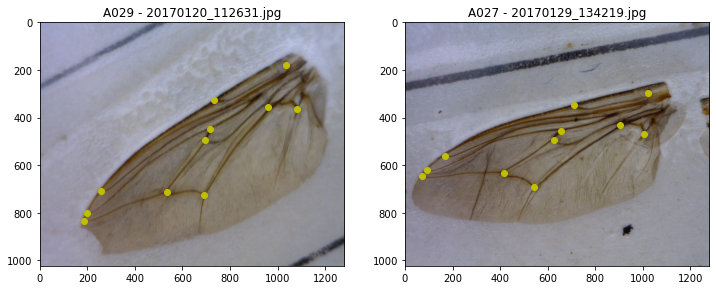

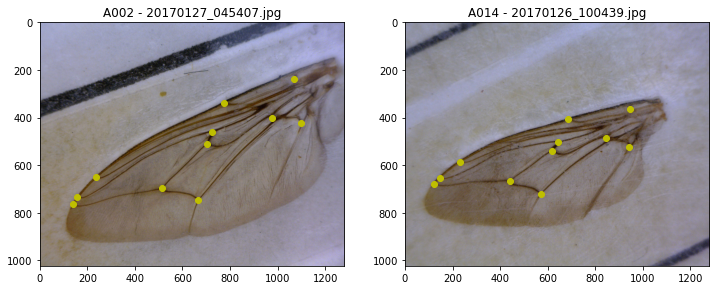

In [8]:
root_path_left = 'DATA/images_left/'
root_path_right = 'DATA/images_right/'

indices_left = np.random.randint(left_line_count, size=2)
indices_right = np.random.randint(right_line_count, size=2)
fig, ax = plt.subplots(1, 2, figsize=FIG_SIZE_SUBPLOT)
print("indices to test coordinates and images", indices_left)
for idx,k in zip(indices_left, range(len(indices_left))):
    image = io.imread(root_path_left + left_file_names[idx])
    ax[k].set_title(left_file_names[idx])
    ax[k].imshow(image)
    for i in range(0, len(left_wing_marks[idx]),2):
        ax[k].scatter(left_wing_marks[idx,i], left_wing_marks[idx,i+1], c='y')
        
fig, ax = plt.subplots(1, 2, figsize=FIG_SIZE_SUBPLOT)
print("indices to test coordinates and images", indices_right)
for idx,k in zip(indices_right, range(len(indices_right))):
    image = io.imread(root_path_right + right_file_names[idx])
    image = np.flip(image, axis=1)
    ax[k].set_title(right_file_names[idx])
    ax[k].imshow(image)
    for i in range(0, len(right_wing_marks[idx]),2):
        ax[k].scatter(right_wing_marks[idx,i], right_wing_marks[idx,i+1], c='y')
    



# Combining and splitting data

In [91]:
# test list needs to be the combined dataset for landmarks
combined_landmarks = np.vstack((left_wing_marks, right_wing_marks))
assert combined_landmarks.shape[0] == left_wing_marks.shape[0] + right_wing_marks.shape[0]
print(combined_landmarks.shape)
# test_list = torch.utils.data.TensorDataset(test_tensor)


train_dataset, validation_dataset, test_dataset  = torch.utils.data.random_split(combined_landmarks, [0.6, 0.2, 0.2], generator=torch.Generator().manual_seed(42))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_dataset.__len__(), shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_dataset.__len__(), shuffle=False)

# just to get the split according to the previous approaches with random seed.
for item in train_loader:
    training_landmarks = item.numpy()
    print(training_landmarks.shape)
    
    
for item in test_loader:
    testing_landmarks = item.numpy()
    print(testing_landmarks.shape)
# for item in train_loader:


(2420, 22)
(1452, 22)
(484, 22)


# Calculate mean baseline

(1452, 22)
mean [1018.68996763  238.89247466  725.05573216  329.48802094  197.99435957
  602.15722769  124.85212287  678.01119063  674.44444945  443.5136084
  105.4747      707.59964477  456.52998147  660.79117218  601.46943395
  707.90209298 1035.59927769  429.18699022  650.54782679  488.53834759
  922.37575069  392.63909601]
train_std [55.9397764  60.86932691 49.87029767 48.65288809 56.50180227 62.88550829
 57.50511839 68.34966644 46.88749241 47.15689685 57.97036182 69.77200524
 49.37578433 51.14324125 48.6443351  48.73019385 50.85295339 59.64873197
 46.50246627 47.00064424 49.40827074 53.9966939 ]


(-4.443056466790068, 1138.3996257223992, 807.3390751219835, 148.05572263739776)

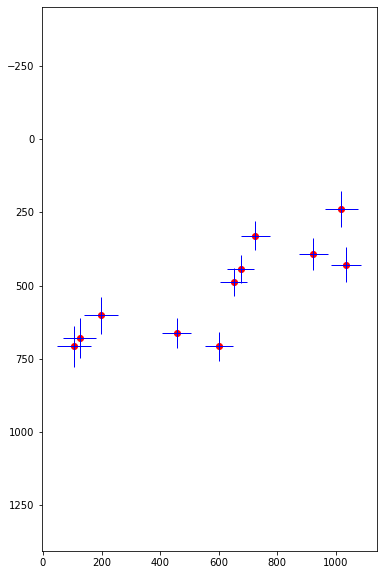

In [99]:
print(training_landmarks.shape)
# calculate stats for wing coordinates
train_mean_marks = np.mean(training_landmarks, axis=0)
train_var_marks = np.var(training_landmarks, axis=0)
train_std_marks = np.std(training_landmarks, axis=0)
print("mean", train_mean_marks)
print("train_std", train_std_marks)
assert train_mean_marks.shape == (22,)
assert train_var_marks.shape == (22,)
assert train_std_marks.shape == (22,)


# plot the mean wing with horizontal and vertical error bars represnting a standard deviation
# flip axes to preserve image orientation
plt.figure(figsize=FIG_SIZE)
plt.xlim([0, IMG_DIM[1]])
plt.ylim([900, 100 ])
for i in range(0, len(train_mean_marks),2):
    plt.scatter(train_mean_marks[i], train_mean_marks[i+1], c='r')
    plt.errorbar(train_mean_marks[i], train_mean_marks[i+1], xerr=train_std_marks[i], yerr=train_std_marks[i+1], c='b', elinewidth=1)


plt.axis('equal')

# Calculate error for the pixels
# test

(484, 11)


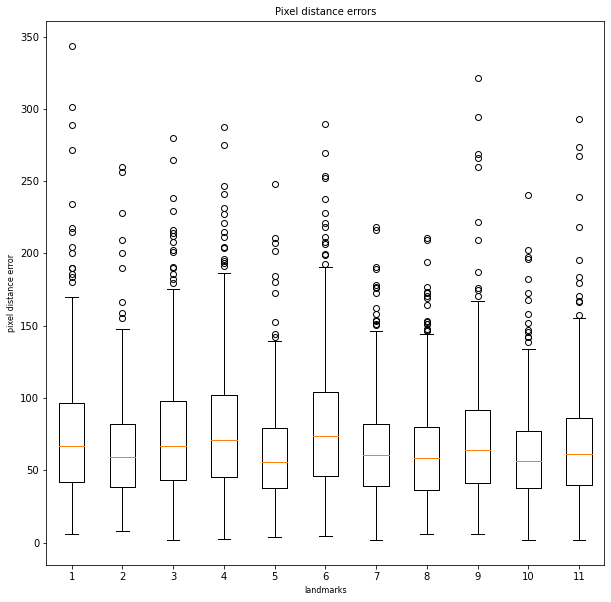

In [96]:
testing_landmarks.shape
test_mean_marks = testing_landmarks.reshape(-1,22)
distance_radicand = (train_mean_marks - testing_landmarks)**2
landmark_errors = np.array([np.sqrt(distance_radicand[:,i] + distance_radicand[:,i+1]) for i in range(0,test_mean_marks.shape[1], 2)]).T

# print(landmark_errors.shape, left_wing_marks.shape, left_mean_marks.shape, distance_radicand.shape)
assert landmark_errors.shape == (testing_landmarks.shape[0], testing_landmarks.shape[1]/2)

print(landmark_errors.shape)

#print(predictions)
# difs = abs(predictions - landmarks)
# difs = difs.detach()

# dis = np.sqrt(difs[:, :,0]**2 + difs[:, :, 1]**2)
plt.figure(figsize=(10,10))
plt.boxplot(landmark_errors)

plt.xlabel('landmarks', fontsize=8)
plt.ylabel('pixel distance error', fontsize=8)
plt.title('Pixel distance errors', fontsize=10)
# plt.savefig('errors_resnet50.png')
plt.show()

In [5]:
# !pip install --upgrade torch torchvision


print(torch.__version__)


1.13.1
